# Reducto extraction from top 4000 pypi packages ordered by downloads 

This notebook presents a simple study of the measures obtained by running the [reducto](https://pypi.org/project/reducto/) package on the 4000 most downloaded pypi packages.

*Section 1* presents the data extraction methodology, *section 2* explores the descriptive statistics of the packages (that could be parsed), *section 3* plots the histograms of the variables, *section 4* presents the linear regression model of the number of downloads explained by the *reducto* variables, and *section 5* presents a the clusters obtained from the 2 first principal components.

## 1. Data

The data extracted corresponds to the packages obtained from: https://hugovk.github.io/top-pypi-packages/,
specifically to the last version of 4000 most downloaded packages from PyPI (obtained from the github repo: [top_pypi_packages](https://github.com/hugovk/top-pypi-packages/blob/master/top-pypi-packages-365-days.json))

From the total number of pacakges, 3647 packages are present:
- 353 of the total failed due to the following reasons:
    - 153 are discarded as the algorithm to obtain the package installed from the corresponding package failed. The name of the package stored internally could not be found. These packages could be included by solving this issue.
        An example of this type is: [google-cloud-core](https://github.com/googleapis/python-cloud-core)
        Many google or azure packages failed in this category.

    - 123 are discarded due to installation issues. an example of this type would be: [pyobjc-framework-modelio](https://pypi.org/project/pyobjc-framework-ModelIO/), a library expected to be installed for macos (the code is run on an ubuntu machine).

    - 77 discareded due to reducto issues. An example of this type: [kafka](https://pypi.org/project/kafka/), which contains source code from older python versions not suported by the ast parser used in *reducto* (python 3.8).

\* *The measures obtained regarding the lines obtained only apply to python code. Only .py files are accounted, other data folders or possible extensions like .c/.h files aren't taken into account.
These measures are obtained pointing to the same module that would be directly importable from python. This means that for packages which include the tests in the distribution [scikit-learn](https://github.com/scikit-learn/scikit-learn), the number of lines will be higher, while other packages which let the tests outside the distribution like [requests](https://github.com/psf/requests) show a lower number of lines.*

#### Import visualization and features

In [1]:
!python -m ipykernel install --user --name=venv

Installed kernelspec venv in /home/agustin/.local/share/jupyter/kernels/venv


In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

import src.visualization.visualize as viz
import src.features.build_features as bf

## 2. Descriptive statistics of the variables

In [4]:
reducto_table = bf.get_reducto_reports_table()
reducto_table.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

,lines,source_lines,blank_lines,docstring_lines,comment_lines,average_function_length,number_of_functions,source_files
count,3.647000e+03,3.647000e+03,3647.000000,3647.000000,3647.000000,3647.000000,3647.000000,3647.000000
mean,1.402416e+04,9.545457e+03,1627.766109,2069.450233,781.485056,12.858514,534.454894,49.217987
std,8.349239e+04,5.984216e+04,9296.191124,18596.750779,3920.814374,40.615570,2418.541991,274.131266
min,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
5%,7.400000e+01,4.700000e+01,11.000000,0.000000,1.000000,2.000000,2.000000,1.000000
25%,4.505000e+02,3.015000e+02,65.000000,24.000000,14.000000,6.000000,21.000000,3.000000
50%,1.603000e+03,1.077000e+03,224.000000,135.000000,71.000000,9.000000,81.000000,8.000000
75%,6.487000e+03,4.250500e+03,827.000000,662.500000,323.500000,14.000000,290.000000,28.000000
95%,4.669150e+04,3.063410e+04,5737.300000,5314.000000,2853.400000,27.000000,1861.200000,163.700000
max,3.424155e+06,2.595086e+06,409215.000000,682666.000000,120610.000000,1562.000000,71735.000000,11315.000000


The total number of packages under study from the original 4000 are 3647. Given the high dispersion across the different packages, the mean values of the variables may be highly skewed, so the median value may be more representative of the results.

Regarding the median number of `lines`, reads 1.603k lines, while the mean value is 14.024k.
The `average_function_length` of the packages is 12.85, with a median of 9 lines (less outliers are found in this variable, expected as we are taking the average of mean values). A mean of 534 `number_of_functions` is found on these packages (81 in median), and the mean/median `source_files` (.py files in the package) are 49.21 and 8 respectively.
The variables `source_lines`, `blank_lines`, `docstring_lines` and `comment_lines` are more interesting when seen as a percentage of the total of lines of each package, shown in the histograms of *section 3*.

###### Packages with the biggest values by field

In [25]:
df = pd.concat([reducto_table.idxmax(), reducto_table.max()], axis=1)
df.columns = ["package name", "value"]
df

,package name,value
lines,azure-mgmt-network,3424155
source_lines,azure-mgmt-network,2595086
blank_lines,azure-mgmt-network,409215
docstring_lines,boto3-type-annotations-with-docs,682666
comment_lines,azure-mgmt-network,120610
average_function_length,js2py,1562
number_of_functions,oci,71735
source_files,plotly,11315


## 3. Histograms of the variables

The variables studied include the `source_lines`, `blank_lines`, `docstring_lines` and `comment_lines` scaled by the total lines:


A log-transformation is applied to the total number of `lines` to normalize the values and simplify the visualization due to the difference in scale across packages.

The distribution of the `average_function_length` is plotted for every package (left), and to the subset of packages with less than 50 lines in average (only 51 packages are extracted), to remove the noise from a those packages with a big average gunction length:

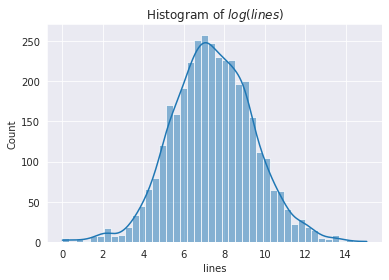

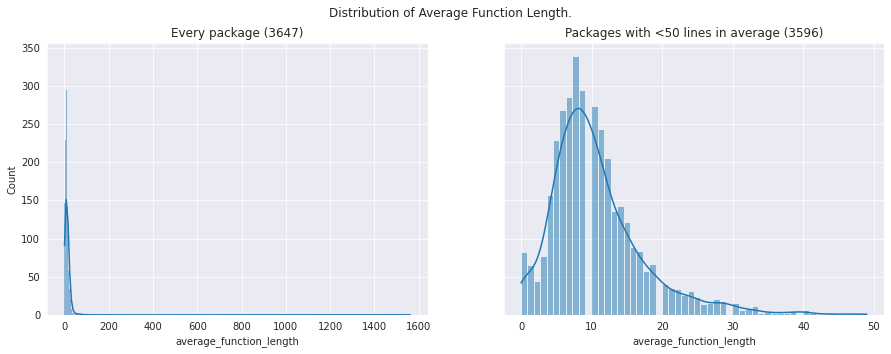

In [39]:
log_lines = reducto_table['lines'].apply(np.log)
sns.histplot(log_lines, kde=True)
plt.title(r"Histogram of $log(lines)$");
viz.plot_average_function_length()

The following figures show the distribution of the relative `source_lines`, `blank_lines`, `docstring_lines` and `comment_lines`:

       source_lines  blank_lines  docstring_lines  comment_lines
count   3537.000000  3537.000000      3537.000000    3537.000000
mean       0.673020     0.148842         0.117746       0.060392
std        0.107706     0.049558         0.109976       0.059175
min        0.090909     0.004505         0.000000       0.000000
25%        0.612697     0.117790         0.035313       0.022140
50%        0.685185     0.144428         0.087448       0.045514
75%        0.742932     0.176039         0.166998       0.079329
max        0.988484     0.500000         0.854545       0.566038


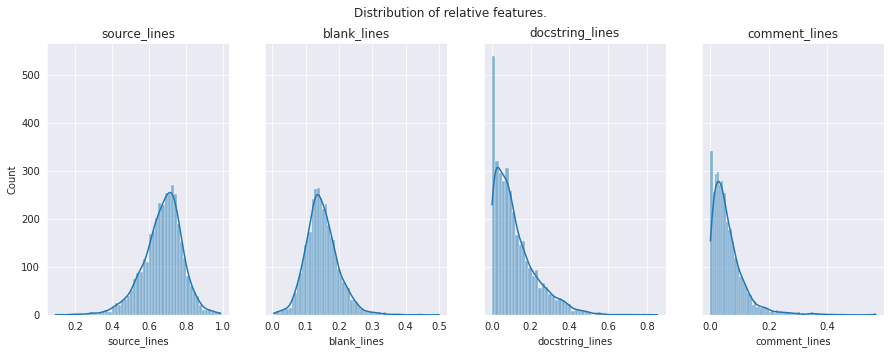

In [40]:
viz.plot_histogram_relative_numbers()
print(bf.get_reducto_reports_relative()[['source_lines', 'blank_lines', 'docstring_lines', 'comment_lines']].describe())

From the previous figures we can see that a the average package in PyPI (from the sample studied here) has a distribution of 67% `source_lines` , 14% `blank_lines`, 11% `docstring_lines` and 6% `comment_lines`.

## 4. Linear regression: downloads per package explained by reducto features

To see if there is any relationship between the variables obtained from `reducto` and the total number of downloads by of each package, the following model is estimated:

$$log(downloads\_per\_package) = \beta_0 + \beta_1 source\_lines + \beta_2 docstring\_lines + \beta_3 comment\_lines + \beta_4 log(average\_function\_length) + \beta_5 log(number\_of\_functions) + \beta_6 log(source\_files) + \epsilon $$

The `downloads_per_package` are transformed to logarithm, as well as the `average_function_lentgh`, the `number_of_functions` and the `source_files`. Things to keep in mind:

- The variables `source_lines`, `docstring_lines`, `comment_lines`, and `blank_lines` are a linear combination, so one has to be removed to estimate the model. In this case `blank_lines` is dropped.

- The total number of `lines` is removed to avoid estimation errors due to multicollinearity, as this variable is highly correlated with `number_of_functions` and `source_files`.

- A correction to the standard errors is applied against heteroscedasticity.

### 4.1. Correlations across variables

The following heatmap shows the correlation accross the different variables:

- The `number_of_functions`, `source_files` are highly correlated with the `lines` of a package (0.91 and 0.83 respectively).

- `source_lines`, `blank_lines`, `docstring_lines` and `comment_lines` are negatively correlated with each other as expected, with the higher magnitude between `source_lines` and `docstring_lines`, which suggests that these variables are interchangeable, when more `source_lines` are present, less `docstring_lines` are expected in average.

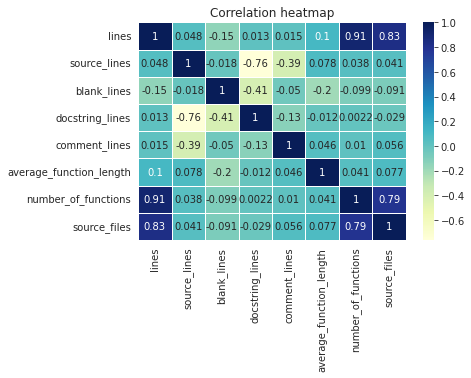

In [44]:
import importlib
importlib.reload(viz)
data = bf.get_reducto_reports_relative()
viz.plot_correlation(data)
plt.title("Correlation heatmap");

### 4.2. Model

Inspecting the linear regression results, the only two variables (apart from the constant) statistically different from zero are the `number_of_functions` and `source_files`.

- The interpretation for `number_of_functions` would be: a 1% increase in the number of functions would **increase** around 8.5% the number of downloads in average.

- A 1% increase in `source_files` would **decrease** around 8.7% the number of downloads in average.

The difference in packages (3537 vs 3647) comes from removing the packages considered outliers (defined as those with over 6 standard deviations in the fields `lines`, `number_of_functions`, `source_files` and `average_function_length`, or a value of 0 in those variables).

Regarding the variance of the `number of downloads` explained by these variables, the Adjusted R-squared statistic suggests that these variables have a low explanatory power. 

In [7]:
import src.models.models as md
import importlib
importlib.reload(md)
model = md.reducto_explain_downloads(log_y=True, log_x=True, drop_columns=['lines'])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.377
Date:                Sun, 03 Oct 2021   Prob (F-statistic):             0.0271
Time:                        21:07:58   Log-Likelihood:                -6729.0
No. Observations:                3537   AIC:                         1.347e+04
Df Residuals:                    3530   BIC:                         1.352e+04
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
constant                  

## 5. Clustering

Finally, an attempt to visualize possible clusters formed by these variables is made by applying the [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) algorithm to the 2 main Principal Components [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) (only 2 PCs are used to simplify the visualization).

The number of clusters is selected using a [silhouette analysis](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).


### 5.1. PC weights

These weights are extracted of the variables transformed by logarithms and standardized, to avoid having the variables like the number of lines getting an excessive weight due to the higher scale.


Variance explained by the 2 components: [0.36712858 0.23567025]
Total: 60.28%.


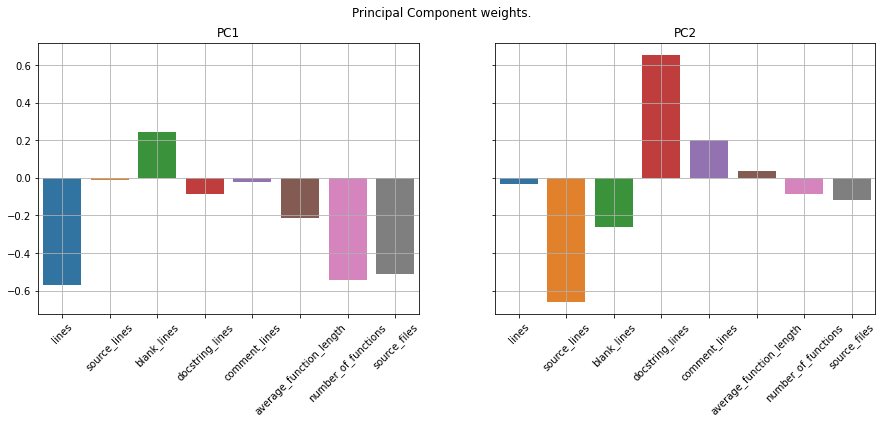

In [8]:
viz.plot_pc_weights()

The first component seems to allocate most of the weight in the variables number of `lines`, `average_function_length`, `number_of_functions` and `source_lines`, wigh negative sign, while the variables (scaled by the number of `lines`) are represented in the second component. This second component mixes positive and negative weights, according with the negative correlation between these variables.

### 5.2. KMeans clusters

The algorithm seems to discriminate between the packages with a number of lines above the average (PC1<0)** vs smaller packages (in terms of python lines of code, remember every other language used for possible extensions isn't tracked here), more information (in terms of variables) should be used to see if there is some structure across different types packages.

**Note**
(PC1<0)** : An example can be seen with *matplotlib*, the variables and weights for this package are:
- features: ( 2.4307685 , -0.26933659, -0.45693385,  0.49524478, -0.04750621, 0.4783165 ,  2.42425339,  2.04149785)
- weights of PC1: (-0.57168787, -0.01308915,  0.2442107 , -0.08547451, -0.02184428, -0.21088967, -0.54474551, -0.51415718)

Which returns a PC1 value of -4.0101206039001625. 

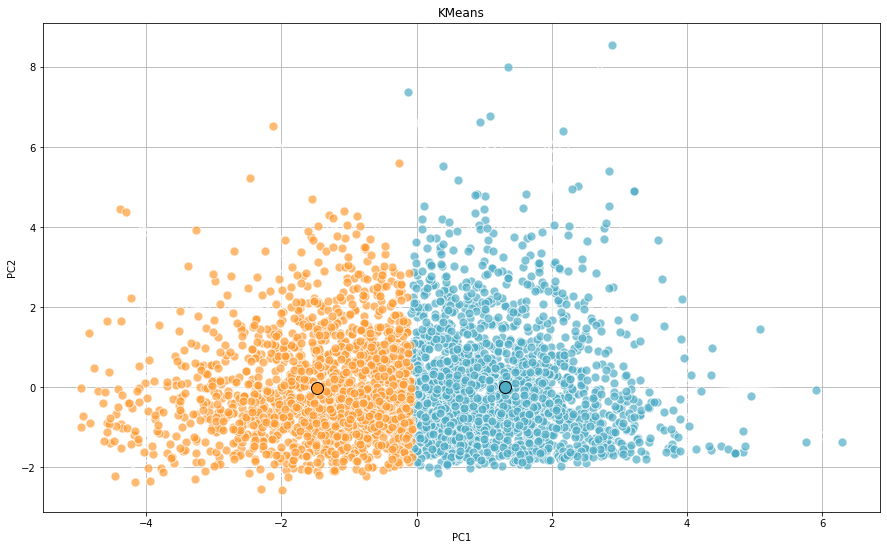

In [9]:
viz.plot_clusters(bf.get_pc(bf.get_reducto_reports_relative(log=True), standardize=True), n_clusters=2)

#### Further research

- The results may be improved if more variables were used in the linear regression, like the ones used in [SourceRank](https://libraries.io/pypi/firmware-variables/sourcerank).
- A higher correlation may be found across variables like the number of stars per package, or the number of contributors.
- Different clustering algorithms may find different types of clusters.
- Associating these metrics to the package (maybe by associating the tags present in the repositories) may show different types of groups. 